In [58]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import math
from utils import get_image, resize_and_pad, transform, mulit_colors, load_yaml

In [2]:
ort.get_available_providers()

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']

# yolo export

```sh
yolo task=segment mode=export imgsz=640 model=weights/yolov8s-seg.pt format=onnx simplify=True device=0

# half=True only compatible with GPU export, i.e. use device=0
yolo task=segment mode=export imgsz=640 model=weights/yolov8s-seg.pt format=onnx simplify=True device=0 half=True
```

# basic

In [3]:
# h w
imgsz = 640, 640

In [4]:
colors: list = mulit_colors(80)
colors[:5]

[(255, 76, 76), (255, 89, 76), (255, 103, 76), (255, 116, 76), (255, 130, 76)]

In [5]:
config: dict = load_yaml("./weights/yolov8.yaml")
config["names"]

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

# prepare image

(1080, 810, 3)


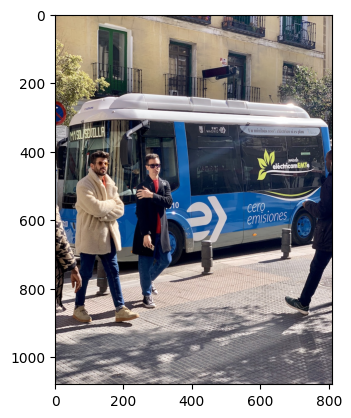

In [6]:
image_rgb = get_image("images/bus.jpg")
print(image_rgb.shape)
plt.imshow(image_rgb)

In [7]:
origin_shape = image_rgb.shape
origin_shape

(1080, 810, 3)

(640, 640, 3) 0.5925925925925926
255 0


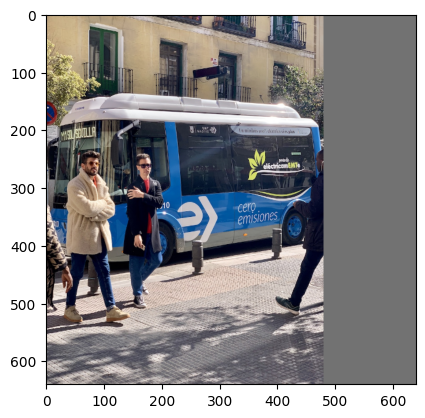

In [8]:
image_reized, ratio = resize_and_pad(image_rgb, imgsz)
print(image_reized.shape, ratio)
print(image_reized.max(), image_reized.min())
plt.imshow(image_reized)

In [9]:
input_array = transform(image_reized)
print(input_array.shape, input_array.max(), input_array.min())

(1, 3, 640, 640) 1.0 0.0


# load model

In [10]:
model_path = "./weights/yolov8s-seg.onnx"
mode = "cuda"

In [11]:
so = ort.SessionOptions()
so.log_severity_level = 3
providers = {
    "cpu":  ["CPUExecutionProvider"],
    # https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html
    "cuda": [
            ("CUDAExecutionProvider", {
                "device_id": 0,
                "arena_extend_strategy": "kNextPowerOfTwo",
                "gpu_mem_limit": 8 * 1024 * 1024 * 1024, # 8GB
                "cudnn_conv_algo_search": "EXHAUSTIVE",
                "do_copy_in_default_stream": True,
            }),
            "CPUExecutionProvider",
        ],
    # tensorrt
    # https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html
    # it is recommended you also register CUDAExecutionProvider to allow Onnx Runtime to assign nodes to CUDA execution provider that TensorRT does not support.
    # set providers to ["TensorrtExecutionProvider", "CUDAExecutionProvider"] with TensorrtExecutionProvider having the higher priority.
    "tensorrt": [
            ("TensorrtExecutionProvider", {
                "device_id": 0,
                "trt_max_workspace_size": 8 * 1024 * 1024 * 1024, # 8GB
                "trt_fp16_enable": False,
                # "trt_timing_cache_enable": True, # Enabling trt_timing_cache_enable will enable ORT TRT to use TensorRT timing cache to accelerate engine build time on a device with the same compute capability.
            }),
            ("CUDAExecutionProvider", {
                "device_id": 0,
                "arena_extend_strategy": "kNextPowerOfTwo",
                "gpu_mem_limit": 8 * 1024 * 1024 * 1024, # 8GB
                "cudnn_conv_algo_search": "EXHAUSTIVE",
                "do_copy_in_default_stream": True,
            }),
            "CPUExecutionProvider",
        ]
}[mode]

In [12]:
session = ort.InferenceSession(model_path, sess_options=so, providers=providers)

In [13]:
inputs  = session.get_inputs()
for i in inputs:
    print(i.name)

images


In [14]:
outputs = session.get_outputs()
for i in outputs:
    print(i.name)

output0
output1


# run model

In [15]:
outputs: list[np.ndarray] = session.run(None, {inputs[0].name: input_array})
len(outputs)

2

# check result

In [16]:
results = outputs[0]
print(results.shape)
results = np.transpose(results, (0, 2, 1))
print(results.shape)

(1, 116, 8400)
(1, 8400, 116)


In [17]:
protos = outputs[1]
protos.shape

(1, 32, 160, 160)

## 前4个值是loc [:4]

In [18]:
results[0, 0, :4]

array([ 3.4205456, 10.974574 , 11.024952 , 25.976355 ], dtype=float32)

## 中间的的值是cls [4:-32]

In [19]:
results[0, 0, 4:-32]

array([3.9339066e-06, 2.3841858e-07, 5.9604645e-07, 1.1920929e-07,
       1.1920929e-07, 1.1920929e-07, 1.1920929e-07, 1.1920929e-07,
       1.1920929e-07, 8.3446503e-07, 1.1920929e-07, 2.3841858e-07,
       1.1920929e-07, 2.3841858e-07, 3.5762787e-07, 2.3841858e-07,
       1.1920929e-07, 1.1920929e-07, 1.1920929e-07, 1.1920929e-07,
       2.3841858e-07, 1.1920929e-07, 1.1920929e-07, 2.3841858e-07,
       3.5762787e-07, 3.5762787e-07, 3.5762787e-07, 2.3841858e-07,
       2.3841858e-07, 1.1920929e-07, 2.3841858e-07, 1.1920929e-07,
       3.5762787e-07, 1.1920929e-07, 2.3841858e-07, 1.1920929e-07,
       1.1920929e-07, 2.3841858e-07, 2.3841858e-07, 3.5762787e-07,
       2.3841858e-07, 2.3841858e-07, 1.1920929e-07, 1.1920929e-07,
       1.1920929e-07, 1.1920929e-07, 3.5762787e-07, 3.5762787e-07,
       1.1920929e-07, 3.5762787e-07, 2.3841858e-07, 2.3841858e-07,
       1.1920929e-07, 1.1920929e-07, 2.3841858e-07, 1.1920929e-07,
       4.7683716e-07, 2.3841858e-07, 8.3446503e-07, 1.1920929e

## 最后32个是maskid [-32:]

In [20]:
results[0, 0, -32:]

array([-0.06280294, -0.19632271, -0.44407758, -0.17172776, -0.44307247,
        0.03239979, -1.1400834 ,  0.1149988 , -0.28580856,  0.09196582,
        0.04995179,  0.29610196, -0.12573068,  0.08295286, -0.02244172,
        0.302768  , -0.08760731, -0.30459842,  0.16707271, -1.0105405 ,
       -0.73448545,  0.21248025,  0.16632545,  0.07487638,  0.3630097 ,
        0.52443767, -0.37896883, -0.220402  , -1.995986  , -1.0019431 ,
       -0.6210052 , -0.031006  ], dtype=float32)

In [21]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

# postprocess

In [22]:
print(results.shape)
print(results.min(), results.max())

(1, 8400, 116)
-2.6370435 637.05396


# nms

In [23]:
def nms(detections_in: np.ndarray, confidence_threshold=0.25, score_threshold=0.2, nms_threshold=0.45) -> list[np.ndarray]:
    """非极大值抑制，没有confidence,只有box和class score

    Args:
        detections_in (np.ndarray):     检测到的数据 [b, 8400, 116] 116 = 4 + 84 + 32
        confidence_threshold (float):   只有得分大于置信度的预测框会被保留下来,越大越严格
        score_threshold (float):        opencv nms分类得分阈值,越大越严格
        nms_threshold (float):          非极大抑制所用到的nms_iou大小,越小越严格

    Returns:
        [n, 1+1+4+32]
        (list[np.ndarray]): list代表每张图片,里面是一个ndarray,代表一张图片的结果,如果图片没有结果就为 []
            [
                np.ndarray([
                    [class_index, confidence, xmin, ymin, xmax, ymax, 32个值],
                    ...
                ]),
            ]
    """
    detections = []
    # 循环batch
    for detection_in in detections_in:
        # 位置坐标
        loc            = detection_in[..., :4]
        # 分类
        cls            = detection_in[..., 4:-32]
        # mask
        mask           = detection_in[..., -32:]

        # 最大分类index
        max_cls_index  = cls.argmax(axis=-1)
        # 最大分类score
        max_cls_score  = cls.max(axis=-1)

        # 位置
        boxes          = loc[max_cls_score > confidence_threshold]
        # 置信度
        confidences    = max_cls_score[max_cls_score > confidence_threshold]
        # 类别index
        class_indexes  = max_cls_index[max_cls_score > confidence_threshold]
        # mask_keep
        mask_index      = mask[max_cls_score > confidence_threshold]

        # [center_x, center_y, w, h] -> [x_min, y_min, w, h]
        boxes[..., 0] -= boxes[..., 2] / 2
        boxes[..., 1] -= boxes[..., 3] / 2

        # 每个类别单独做nms
        detection = []
        unique_indexes = np.unique(class_indexes)
        for unique_index in unique_indexes:
            boxes_          = boxes[class_indexes==unique_index]
            confidences_    = confidences[class_indexes==unique_index]
            class_indexes_  = class_indexes[class_indexes==unique_index]
            mask_keep_      = mask_index[class_indexes==unique_index]

            # nms
            nms_indexes     = cv2.dnn.NMSBoxes(boxes_, confidences_, score_threshold, nms_threshold)

            # [x_min, y_min, w, h] -> [x_min, y_min, x_max, y_max]
            boxes_[..., 2] += boxes_[..., 0]
            boxes_[..., 3] += boxes_[..., 1]

            # 过滤
            detection.append(
                np.concatenate(
                    (
                        np.expand_dims(class_indexes_[nms_indexes], -1),
                        np.expand_dims(confidences_[nms_indexes], -1),
                        boxes_[nms_indexes],
                        mask_keep_[nms_indexes],
                    ),
                    axis=-1,
                )
            )

        # 没有检测到添加空数组
        if len(detection) == 0:
            detections.append([])
        else:
            detections.append(np.concatenate(detection, axis=0))

    return detections

In [24]:
nms_results = nms(results)
print(nms_results[0].shape)

(6, 38)


In [25]:
# 分类
classes = nms_results[0][:, 0]
classes.shape

(6,)

In [26]:
# 得分
scores = nms_results[0][:, 1]
scores.shape

(6,)

In [27]:
# 位置
bboxes = nms_results[0][:, 2:6]
bboxes.shape

(6, 4)

In [28]:
# mask_index
masks_index = nms_results[0][:, 6:]
masks_index.shape

(6, 32)

# mask后处理

In [29]:
# https://github.com/ultralytics/ultralytics/blob/main/ultralytics/utils/ops.py#L598
def crop_mask(masks, boxes):
    """
    It takes a mask and a bounding box, and returns a mask that is cropped to the bounding box.

    Args:
        masks (torch.Tensor): [n, h, w] tensor of masks
        boxes (torch.Tensor): [n, 4] tensor of bbox coordinates in relative point form

    Returns:
        (torch.Tensor): The masks are being cropped to the bounding box.
    """
    n, h, w = masks.shape
    x1, y1, x2, y2 = np.split(boxes[:, :, None], 4, axis=1)  # x1 shape(n,1,1)
    r = np.arange(w, dtype=x1.dtype)[None, None, :]  # rows shape(1,1,w)
    c = np.arange(h, dtype=x1.dtype)[None, :, None]  # cols shape(1,h,1)

    return masks * ((r >= x1) * (r < x2) * (c >= y1) * (c < y2))
crop_mask(np.random.random((6, 160, 120)), np.random.random((6, 4))).shape

(6, 160, 120)

In [30]:
# https://github.com/ultralytics/ultralytics/blob/main/ultralytics/utils/ops.py#L638
def process_mask(protos: np.ndarray, masks_index: np.ndarray, bboxes: np.ndarray, shape: tuple) -> np.ndarray:
    """
    Apply masks to bounding boxes using the output of the mask head.

    Args:
        protos (np.ndarray): A tensor of shape [mask_dim, mask_h, mask_w].                                            [32, 160, 120]
        masks_in (np.ndarray): A tensor of shape [n, mask_dim], where n is the number of masks after NMS.             [6, 32]
        bboxes (np.ndarray): A tensor of shape [n, 4], where n is the number of masks after NMS.                      [6, 4]
        shape (tuple): A tuple of integers representing the size of the input image in the format (h, w).             [640, 480]

    Returns:
        (np.ndarray): A binary mask tensor of shape [n, h, w], where n is the number of masks after NMS, and h and w
            are the height and width of the input image. The mask is applied to the bounding boxes.
    """

    c, mh, mw = protos.shape  # CHW
    ih, iw = shape
    masks = sigmoid((masks_index @ protos.reshape(c, -1))).reshape(-1, mh, mw)  # CHW   [6, 32] @ [32, 160*120]

    downsampled_bboxes = bboxes.copy()
    downsampled_bboxes[:, 0] *= mw / iw
    downsampled_bboxes[:, 2] *= mw / iw
    downsampled_bboxes[:, 3] *= mh / ih
    downsampled_bboxes[:, 1] *= mh / ih

    masks = crop_mask(masks, downsampled_bboxes)  # CHW
    return (masks > 0.5).astype(np.float32)

process_mask(
    np.random.random([32, 160, 120]),
    np.random.random([6, 32]),
    np.random.random([6, 4]),
    [640, 480],
).shape

(6, 160, 120)

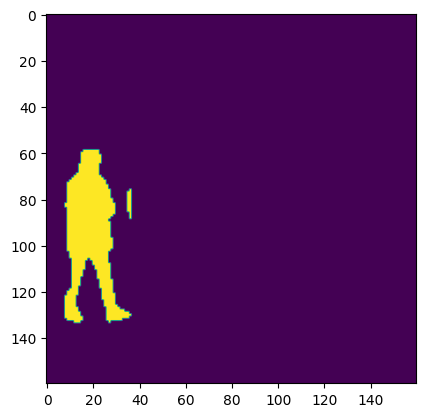

In [31]:
masks = process_mask(protos[0], masks_index, bboxes, [640, 640])
plt.imshow(masks[0])

# 坐标还原到原图尺寸

In [32]:
# h w
imgsz = 640, 640

In [33]:
def to_origin_size(
    bboxes_in: np.ndarray,
    ratio: float,
    origin_shape: list[int],
    masks: np.ndarray | None = None
) -> tuple[np.ndarray]:
    """将将检测结果的坐标还原到原图尺寸

    Args:
        bboxes_in (np.ndarray): [n, 6]
                [
                    [class_index, confidence, xmin, ymin, xmax, ymax],
                    ...
                ]
        ratio (float): 缩放比例
        origin_shape (list[int]): 原始形状 [h, w]
        masks (np.ndarray): mask [n, mask_h, mask_w]

    Returns:
        tuple[np.ndarray]
    """
    if len(bboxes_in) == 0:
        return bboxes_in, masks

    bboxes = bboxes_in.copy()
    # 还原到原图尺寸
    bboxes /= ratio

    # 防止框超出图片边界, 前面判断为True/False,后面选择更改的列,不选择更改的列会将整行都改为0
    bboxes[bboxes[..., 0] < 0.0, 0] = 0.0
    bboxes[bboxes[..., 1] < 0.0, 1] = 0.0
    bboxes[bboxes[..., 2] > origin_shape[1], 2] = origin_shape[1]
    bboxes[bboxes[..., 3] > origin_shape[0], 3] = origin_shape[0]

    if masks is not None:
        # [n, mask_h, mask_w] -> [mask_h, mask_w, n] -> [max_h_w, max_h_w, n]
        masks = cv2.resize(masks.transpose(1, 2, 0), (int(imgsz[1] / ratio), int(imgsz[0] / ratio)), interpolation=cv2.INTER_LINEAR)
        # [max_h_w, max_h_w, n] -> [origin_h, origin_w, n]
        masks = masks[:origin_shape[0], :origin_shape[1]]
        # [origin_h, origin_w, n] -> [n, origin_h, origin_w]
        masks = masks.transpose(2, 0, 1).round()

    return bboxes, masks

In [34]:
resized_bboxes, resized_masks = to_origin_size(bboxes, ratio, origin_shape, masks)
print(resized_bboxes.shape)
print(resized_masks.shape)
print(resized_bboxes.min(), resized_bboxes.max())
print(np.unique(resized_masks))

(6, 4)
(6, 1080, 810)
0.3132455348968506 903.1683540344238
[0. 1.]


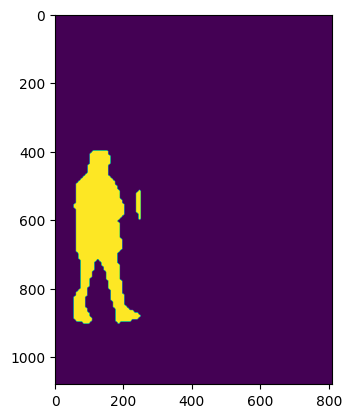

In [35]:
plt.imshow(resized_masks[0])

# 原图 + mask

In [36]:
classes

array([ 0.,  0.,  0.,  0.,  5., 27.])

In [37]:
np.array(colors)[0]

array([255,  76,  76])

In [38]:
def add_mask(classes: np.ndarray, masks: np.ndarray, image: np.ndarray) -> np.ndarray:
    """image + mask
    Args:
        classes (np.ndarray): 类别 [n]
        masks (np.ndarray): mask [n, origin_h, origin_w]
        image (np.ndarray): 原图  [origin_h, origin_w, 3]

    Returns:
        np.ndarray: image + mask [origin_h, origin_w, 3]
    """
    # 区分前景和背景(原因是背景为0,类别id也有为0的,会重复,所以要提前找出背景为0的位置)
    resized_masks_foreground = (masks.max(axis=0) != 0).astype(np.uint8)
    # 分类 * 背景
    resized_masks_ = (classes[:, None, None] * masks).astype(np.uint8)
    # 获取当前位置的最大类别
    resized_masks_ = resized_masks_.max(axis=0)
    # 类别 -> color
    resized_masks_ = np.array(colors)[resized_masks_].astype(np.uint8)
    # 忽略背景
    resized_masks_ *= resized_masks_foreground[:, :, None]
    # 叠加原图
    mask_image = cv2.addWeighted(image, 0.8, resized_masks_, 0.6, 1)
    return mask_image

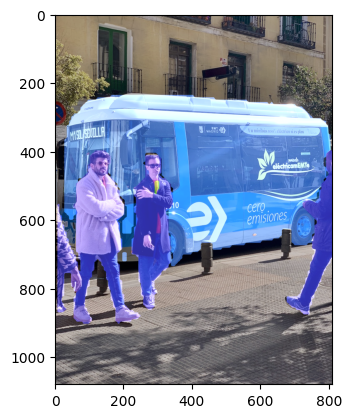

In [39]:
mask_image = add_mask(classes, resized_masks, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
plt.imshow(cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB))

# 画图

In [40]:
def figure(classes: np.ndarray, scores: np.ndarray, resized_bboxes: np.ndarray, image: np.ndarray) -> np.ndarray:
    """将框和mask画到原图

    Args:
        classes (np.ndarray): [n]
        scores (np.ndarray): [n]
        resized_bboxes (np.ndarray): [n, 4]
                [
                    [xmin, ymin, xmax, ymax],
                    ...
                ]
        image (np.ndarray): 原图

    Returns:
        np.ndarray: 绘制的图
    """
    if len(classes) == 0:
        # 返回原图
        return image

    # Print results and save Figure with detections
    for i, (class_id, confidence, resized_bbox) in enumerate(zip(classes, scores, resized_bboxes)):
        classId    = int(class_id)
        xmin       = int(resized_bbox[0])
        ymin       = int(resized_bbox[1])
        xmax       = int(resized_bbox[2])
        ymax       = int(resized_bbox[3])

        # 绘制框
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), colors[classId], 2)

        # 直接在原图上绘制文字背景，不透明
        # image = cv2.rectangle(image, (xmin, ymin - 20), (xmax, ymax), colors[classId], cv2.FILLED)
        # 文字
        label = str(config["names"][classId]) + " " + "{:.2f}".format(confidence)
        w, h = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]  # text width, height

        # 添加文字背景
        temp_image = np.zeros(image.shape).astype(np.uint8)
        temp_image = cv2.rectangle(temp_image, (xmin, ymin - 20 if ymin > 20 else ymin + h + 10), (xmax, ymin), colors[classId], cv2.FILLED)
        # 叠加原图和文字背景，文字背景是透明的
        image = cv2.addWeighted(image, 1.0, temp_image, 0.7, 1)

        # 添加文字
        image = cv2.putText(
            img       = image,
            text      = label,
            org       = (xmin, ymin - 5 if ymin > 20 else ymin + h + 5),
            fontFace  = 0,
            fontScale = 0.5,
            color     = (0, 0, 0),
            thickness = 1,
            lineType  = cv2.LINE_AA,
        )

    return image

In [41]:
image_draw = figure(classes, scores, resized_bboxes, mask_image)

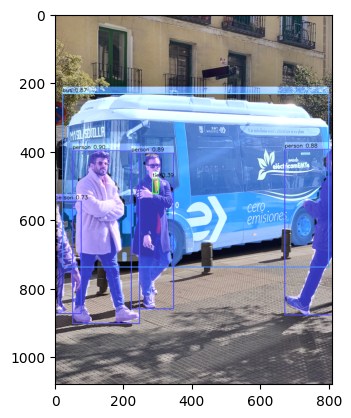

In [42]:
plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))

# result

In [43]:
classes

array([ 0.,  0.,  0.,  0.,  5., 27.])

In [44]:
scores

array([0.90120924, 0.88628608, 0.88437384, 0.73194641, 0.87167364,
       0.39266706])

In [46]:
resized_bboxes.astype(np.int32)

array([[ 51, 398, 246, 903],
       [222, 405, 345, 860],
       [669, 394, 809, 878],
       [  0, 545,  76, 874],
       [ 22, 232, 797, 738],
       [284, 480, 301, 524]])

In [48]:
resized_masks.shape

(6, 1080, 810)

In [57]:
masks_num = resized_masks.shape[0]
masks_num / 4

1.5

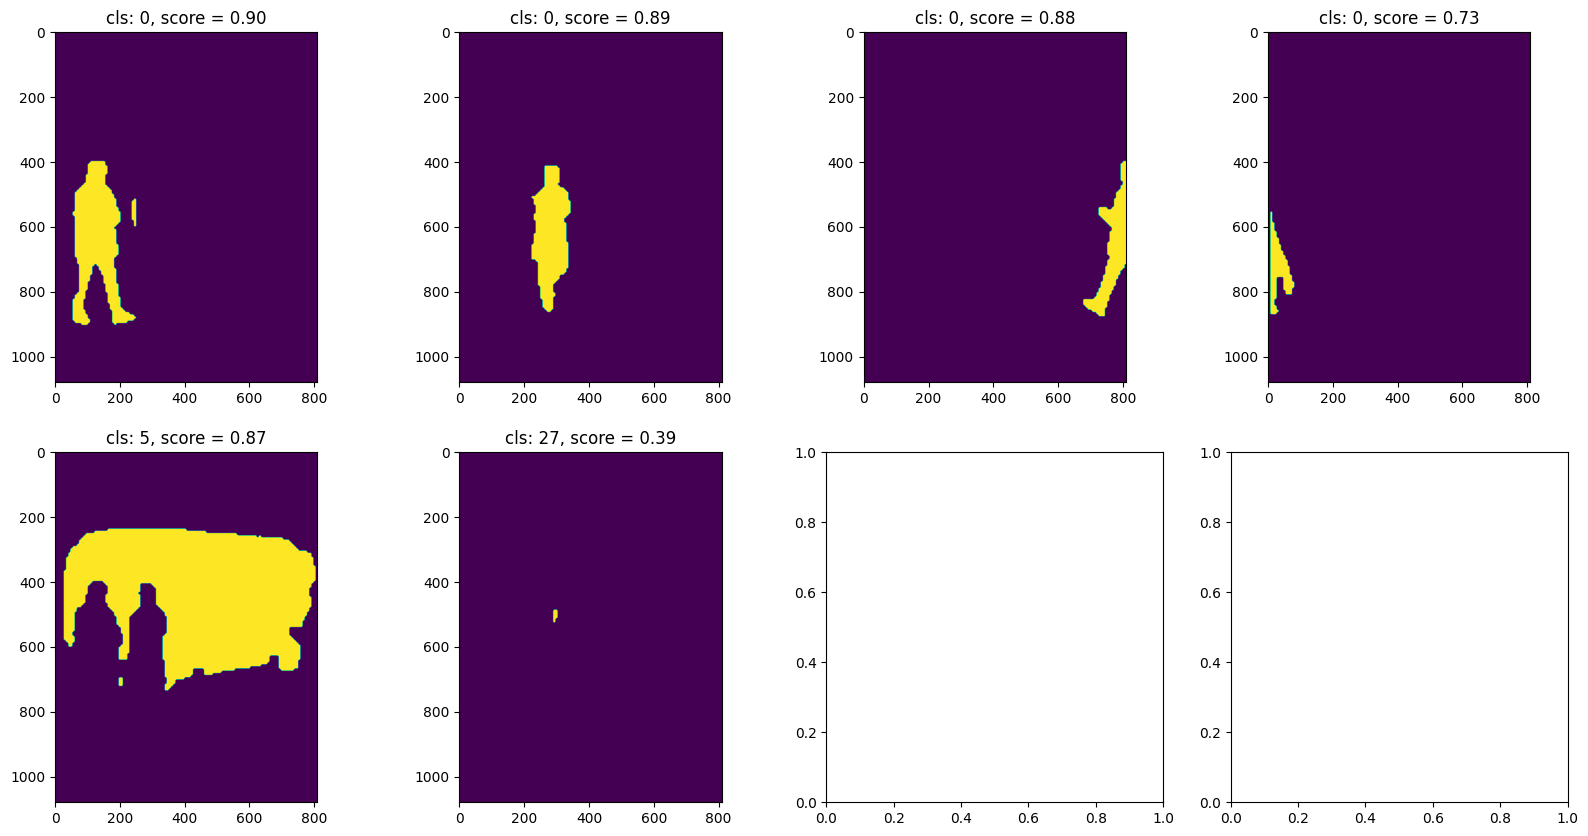

In [69]:
fig, axes = plt.subplots(ncols=4, nrows=math.ceil(masks_num / 4), figsize=(20, 10))
for classes_id, score, m, ax in zip(classes, scores, resized_masks, axes.flatten()):
    ax.imshow(m)
    ax.set_title(f"cls: {int(classes_id)}, score = {'{:.2f}'.format(score)}")